In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb
df=pd.read_csv('initial_dataset.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17919 entries, 0 to 17918
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Case_number                     17919 non-null  object 
 1   District_code                   17919 non-null  int64  
 2   District_name                   17919 non-null  object 
 3   Neighborhood_code               17919 non-null  int64  
 4   Neighborhood_name               17919 non-null  object 
 5   Street_code                     17919 non-null  int64  
 6   Street_name                     17919 non-null  object 
 7   Postal_number                   17919 non-null  object 
 8   Week_day                        17919 non-null  object 
 9   Year                            17919 non-null  int64  
 10  Month                           17919 non-null  int64  
 11  Month_name                      17919 non-null  object 
 12  Day_month                       

In [3]:
df=df[['Week_day', 'Month', 'Day_month', 'Time', 'Day', 'TM', 'PPT', 'VVM10']]

In [4]:
import pandas as pd

def time_segmented():

    # Convertir 'Day' a formato datetime y ordenar por 'Day' y 'Time'
    df['Day'] = pd.to_datetime(df['Day'], format='%d/%m/%Y')
    df.sort_values(['Day', 'Time'], inplace=True)

    # Definir los segmentos de tiempo
    def assign_time_segment(time):
        if 6 <= time < 10:
            return '6-10'
        elif 10 <= time < 14:
            return '10-14'
        elif 14 <= time < 18:
            return '14-18'
        elif 18 <= time < 22:
            return '18-22'
        elif 2 <= time < 4:
            return '2-4'
        else:
            return '22-2'

    # Aplicar la función para crear una nueva columna para el segmento de tiempo
    df['Time_Segment'] = df['Time'].apply(assign_time_segment)

    # Mapear Time_Segment a un valor numérico sortable
    time_segment_sort_order = {'2-4':0, '6-10': 1, '10-14': 2, '14-18': 3, '18-22': 4, '22-2': 5 }
    df['Time_Segment_Sort'] = df['Time_Segment'].map(time_segment_sort_order)

    # Mostrar el DataFrame resultante
    df

# Llamar a la función
time_segmented()


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17919 entries, 0 to 17918
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Week_day           17919 non-null  object        
 1   Month              17919 non-null  int64         
 2   Day_month          17919 non-null  int64         
 3   Time               17919 non-null  int64         
 4   Day                17919 non-null  datetime64[ns]
 5   TM                 17919 non-null  float64       
 6   PPT                17919 non-null  float64       
 7   VVM10              17919 non-null  float64       
 8   Time_Segment       17919 non-null  object        
 9   Time_Segment_Sort  17919 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(4), object(2)
memory usage: 1.5+ MB


In [6]:
import pandas as pd

def time_segmented(df):
    # Create a representative DataFrame for unique 'Day' and additional columns
    columns_to_carry_over = ['Day','Week_day', 'Day_month', 'Month', 'TM', 'PPT', 'VVM10']
    representative_df = df[columns_to_carry_over].drop_duplicates('Day')

    accident_counts = df.groupby(['Day', 'Time_Segment']).size().reset_index(name='Accidents')

    # Create a DataFrame with all combinations of 'Day' and 'Time_Segment'
    time_segments = ['2-6', '6-10', '10-14', '14-18', '18-22', '22-2']
    all_combinations = pd.MultiIndex.from_product([df['Day'].unique(), time_segments],
                                                  names=['Day', 'Time_Segment']).to_frame(index=False)
    time_segment_sort_order = {'2-6': 0, '6-10': 1, '10-14': 2, '14-18': 3, '18-22': 4, '22-2': 5}
    all_combinations['Time_Segment_Sort'] = all_combinations['Time_Segment'].map(time_segment_sort_order)

    # Merge the accident counts with all combinations, filling missing values with 0
    final_df = all_combinations.merge(accident_counts, on=['Day', 'Time_Segment'], how='left').fillna(0)

    # Ensure 'Accidents' column is integer type
    final_df['Accidents'] = final_df['Accidents'].astype(int)

    # Merge the final_df with the representative_df to carry over additional columns
    final_df = final_df.merge(representative_df, on='Day', how='left')

    # Sort the final DataFrame by 'Day' and 'Time_Segment_Sort'
    final_df.sort_values(by=['Day', 'Time_Segment_Sort'], inplace=True)

    # Drop the 'Time_Segment_Sort' column as it's no longer needed
    final_df.drop('Time_Segment_Sort', axis=1, inplace=True)

    return final_df

# Suponiendo que ya tienes definida la variable df con tu DataFrame original
final_df = time_segmented(df)



In [7]:
final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10
0,2021-01-01,2-6,0,Friday,1,1,8.9,0.1,1.9
1,2021-01-01,6-10,0,Friday,1,1,8.9,0.1,1.9
2,2021-01-01,10-14,5,Friday,1,1,8.9,0.1,1.9
3,2021-01-01,14-18,0,Friday,1,1,8.9,0.1,1.9
4,2021-01-01,18-22,7,Friday,1,1,8.9,0.1,1.9
...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,17.2,0.0,1.9
4376,2022-12-31,10-14,6,Saturday,31,12,17.2,0.0,1.9
4377,2022-12-31,14-18,4,Saturday,31,12,17.2,0.0,1.9
4378,2022-12-31,18-22,5,Saturday,31,12,17.2,0.0,1.9


In [8]:
umbral = 4
final_df['Exceeds Threshold'] = final_df['Accidents'].apply(lambda x: 1 if x >= umbral else 0)

In [9]:
final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold
0,2021-01-01,2-6,0,Friday,1,1,8.9,0.1,1.9,0
1,2021-01-01,6-10,0,Friday,1,1,8.9,0.1,1.9,0
2,2021-01-01,10-14,5,Friday,1,1,8.9,0.1,1.9,1
3,2021-01-01,14-18,0,Friday,1,1,8.9,0.1,1.9,0
4,2021-01-01,18-22,7,Friday,1,1,8.9,0.1,1.9,1
...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,17.2,0.0,1.9,0
4376,2022-12-31,10-14,6,Saturday,31,12,17.2,0.0,1.9,1
4377,2022-12-31,14-18,4,Saturday,31,12,17.2,0.0,1.9,1
4378,2022-12-31,18-22,5,Saturday,31,12,17.2,0.0,1.9,1


In [10]:
import datetime

def is_holiday(day, day_of_week):
    # Create a dictionary of holiday dates
    holidays = {
        '01/01/2021': 'New Year',
        '06/01/2021': 'Epiphany',
        '02/04/2021': 'Divendres Sant',
        '05/04/2021': 'Pascua',
        '01/05/2021': 'Mayo',
        '24/05/2021': 'Sant Joan1',
        '24/06/2021': 'Sant Joan',
        '11/09/2021': 'Asumpcio',
        '24/09/2021': 'Merce',
        '12/10/2021': 'Hispanidad',
        '01/11/2021': 'Tots sants',
        '06/12/2021': 'Constitucio',
        '08/12/2021': 'Constitucio2',
        '25/12/2021': 'St Esteve',
        '01/01/2022': 'New Year',
        '06/01/2022': 'Epiphany',
        '15/04/2022': 'Divendres Sant',
        '18/04/2022': 'Pascua',
        '06/06/2022': 'Pascua 2',
        '24/06/2022': 'Sant Joan',
        '15/08/2022': 'Asumpcio',
        '24/09/2022': 'Merce',
        '26/09/2022': 'Merce2',
        '12/10/2022': 'Hispanidad',
        '01/11/2022': 'Tots sants',
        '06/12/2022': 'Constitucio',
        '08/12/2022': 'Constitucio2',
        '26/12/2022': 'St Esteve',
    }
    # Check if the day is a holiday or weekend
    if day in holidays or day_of_week in ['Saturday', 'Sunday']:
        return 'Yes'
    else:
        return 'No'

# Assuming 'Dia' contains the date and 'Day' contains the day of the week
final_df['Holiday'] = final_df.apply(lambda row: is_holiday(row['Day'], row['Week_day']), axis=1)

In [11]:
final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday
0,2021-01-01,2-6,0,Friday,1,1,8.9,0.1,1.9,0,No
1,2021-01-01,6-10,0,Friday,1,1,8.9,0.1,1.9,0,No
2,2021-01-01,10-14,5,Friday,1,1,8.9,0.1,1.9,1,No
3,2021-01-01,14-18,0,Friday,1,1,8.9,0.1,1.9,0,No
4,2021-01-01,18-22,7,Friday,1,1,8.9,0.1,1.9,1,No
...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,17.2,0.0,1.9,0,Yes
4376,2022-12-31,10-14,6,Saturday,31,12,17.2,0.0,1.9,1,Yes
4377,2022-12-31,14-18,4,Saturday,31,12,17.2,0.0,1.9,1,Yes
4378,2022-12-31,18-22,5,Saturday,31,12,17.2,0.0,1.9,1,Yes


In [12]:
import pandas as pd

def get_vacation_week(df, holidays):
    # Convertir las fechas de los festivos a objetos de datetime
    holiday_dates = pd.to_datetime(list(holidays.keys()), format='%d/%m/%Y')
    
    # Extraer el número de semana de cada día festivo
    holiday_week_numbers = holiday_dates.isocalendar().week.unique()
    
    # Agregar una columna 'Vacation_week' al DataFrame y asignar valores 1 o 0
    df['Vacation_week'] = df['Day'].apply(
        lambda x: 1 if pd.to_datetime(x, format='%d/%m/%Y').isocalendar()[1] in holiday_week_numbers else 0
    )
    
    return df


holidays =  {
        '01/01/2021': 'New Year',
        '06/01/2021': 'Epiphany',
        '02/04/2021': 'Divendres Sant',
        '05/04/2021': 'Pascua',
        '01/05/2021': 'Mayo',
        '24/05/2021': 'Sant Joan1',
        '24/06/2021': 'Sant Joan',
        '11/09/2021': 'Asumpcio',
        '24/09/2021': 'Merce',
        '12/10/2021': 'Hispanidad',
        '01/11/2021': 'Tots sants',
        '06/12/2021': 'Constitucio',
        '08/12/2021': 'Constitucio2',
        '25/12/2021': 'St Esteve',
        '01/01/2022': 'New Year',
        '06/01/2022': 'Epiphany',
        '15/04/2022': 'Divendres Sant',
        '18/04/2022': 'Pascua',
        '06/06/2022': 'Pascua 2',
        '24/06/2022': 'Sant Joan',
        '15/08/2022': 'Asumpcio',
        '24/09/2022': 'Merce',
        '26/09/2022': 'Merce2',
        '12/10/2022': 'Hispanidad',
        '01/11/2022': 'Tots sants',
        '06/12/2022': 'Constitucio',
        '08/12/2022': 'Constitucio2',
        '26/12/2022': 'St Esteve',
    }
    

final_df = get_vacation_week(final_df, holidays)



In [13]:
final_df['Vacation_week'].value_counts()

0    2856
1    1524
Name: Vacation_week, dtype: int64

In [14]:
def is_holiday(day, day_of_week):
    # Create a dictionary of holiday dates
    holidays = {
        '05/04/2021': 'New Year',
        '24/05/2021': 'Epiphany',
        '12/10/2021': 'Divendres Sant',
        '01/11/2021': 'Pascua',
        '8/12/2021': 'Mayo',
        '18/04/2022': 'Sant Joan1',
        '06/06/2022': 'Sant Joan',
        '15/08/2022': 'Asumpcio',
        '01/11/2022': 'Merce',
        '06/12/2022': 'Hispanidad',
        '26/12/2022': 'Hispanidad'
      
    }
    # Check if the day is a holiday or weekend
    if day in holidays or day_of_week in ['Sunday']:
        return 'Yes'
    else:
        return 'No'

# Assuming 'Dia' contains the date and 'Day' contains the day of the week
final_df['Weekend Return'] = final_df.apply(lambda row: is_holiday(row['Day'], row['Week_day']), axis=1)

In [15]:
final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return
0,2021-01-01,2-6,0,Friday,1,1,8.9,0.1,1.9,0,No,1,No
1,2021-01-01,6-10,0,Friday,1,1,8.9,0.1,1.9,0,No,1,No
2,2021-01-01,10-14,5,Friday,1,1,8.9,0.1,1.9,1,No,1,No
3,2021-01-01,14-18,0,Friday,1,1,8.9,0.1,1.9,0,No,1,No
4,2021-01-01,18-22,7,Friday,1,1,8.9,0.1,1.9,1,No,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,17.2,0.0,1.9,0,Yes,1,No
4376,2022-12-31,10-14,6,Saturday,31,12,17.2,0.0,1.9,1,Yes,1,No
4377,2022-12-31,14-18,4,Saturday,31,12,17.2,0.0,1.9,1,Yes,1,No
4378,2022-12-31,18-22,5,Saturday,31,12,17.2,0.0,1.9,1,Yes,1,No


In [16]:
import pandas as pd

# Asumiendo que 'df1' es tu DataFrame y 'PPT' es tu columna de precipitación
# Convierte la columna 'PPT' a tipo numérico
final_df['PPT'] = pd.to_numeric(final_df['PPT'], errors='coerce')

# Define una función para asignar categorías
def categorize_ppt(value):
    if value >= 10:
        return 'High'
    elif 1 <= value < 10:
        return 'Medium'
    elif 0 < value < 1:
        return 'Low'
    else:
        return 'None'  # Puedes ajustar esta lógica según tus necesidades

# Aplica la función de categorización a la columna 'PPT'
final_df['PPT'] = final_df['PPT'].apply(lambda x: categorize_ppt(x))

final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return
0,2021-01-01,2-6,0,Friday,1,1,8.9,Low,1.9,0,No,1,No
1,2021-01-01,6-10,0,Friday,1,1,8.9,Low,1.9,0,No,1,No
2,2021-01-01,10-14,5,Friday,1,1,8.9,Low,1.9,1,No,1,No
3,2021-01-01,14-18,0,Friday,1,1,8.9,Low,1.9,0,No,1,No
4,2021-01-01,18-22,7,Friday,1,1,8.9,Low,1.9,1,No,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,17.2,None,1.9,0,Yes,1,No
4376,2022-12-31,10-14,6,Saturday,31,12,17.2,None,1.9,1,Yes,1,No
4377,2022-12-31,14-18,4,Saturday,31,12,17.2,None,1.9,1,Yes,1,No
4378,2022-12-31,18-22,5,Saturday,31,12,17.2,None,1.9,1,Yes,1,No


In [17]:
import pandas as pd

# Asumiendo que 'df1' es tu DataFrame y 'PPT' es tu columna de precipitación
# Convierte la columna 'PPT' a tipo numérico
final_df['TM'] = pd.to_numeric(final_df['TM'], errors='coerce')

# Define una función para asignar categorías
def categorize_ppt(value):
    if value > 25:
        return 'High'
    elif 15 <= value <= 25:
        return 'Medium'
    elif value < 15:
        return 'Low'
    else:
        return None  # Puedes ajustar esta lógica según tus necesidades

# Aplica la función de categorización a la columna 'PPT'
final_df['TM'] = final_df['TM'].apply(lambda x: categorize_ppt(x))

final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return
0,2021-01-01,2-6,0,Friday,1,1,Low,Low,1.9,0,No,1,No
1,2021-01-01,6-10,0,Friday,1,1,Low,Low,1.9,0,No,1,No
2,2021-01-01,10-14,5,Friday,1,1,Low,Low,1.9,1,No,1,No
3,2021-01-01,14-18,0,Friday,1,1,Low,Low,1.9,0,No,1,No
4,2021-01-01,18-22,7,Friday,1,1,Low,Low,1.9,1,No,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,Medium,None,1.9,0,Yes,1,No
4376,2022-12-31,10-14,6,Saturday,31,12,Medium,None,1.9,1,Yes,1,No
4377,2022-12-31,14-18,4,Saturday,31,12,Medium,None,1.9,1,Yes,1,No
4378,2022-12-31,18-22,5,Saturday,31,12,Medium,None,1.9,1,Yes,1,No


In [18]:
import pandas as pd

# Asumiendo que 'df1' es tu DataFrame y 'PPT' es tu columna de precipitación
# Convierte la columna 'PPT' a tipo numérico
final_df['VVM10'] = pd.to_numeric(final_df['VVM10'], errors='coerce')

# Define una función para asignar categorías
def categorize_ppt(value):
    if value > 2:
        return 'High'
    elif 1 <= value <= 2:
        return 'Medium'
    elif value < 1:
        return 'Low'
    else:
        return None  # Puedes ajustar esta lógica según tus necesidades

# Aplica la función de categorización a la columna 'PPT'
final_df['VVM10'] = final_df['VVM10'].apply(lambda x: categorize_ppt(x))

final_df

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return
0,2021-01-01,2-6,0,Friday,1,1,Low,Low,Medium,0,No,1,No
1,2021-01-01,6-10,0,Friday,1,1,Low,Low,Medium,0,No,1,No
2,2021-01-01,10-14,5,Friday,1,1,Low,Low,Medium,1,No,1,No
3,2021-01-01,14-18,0,Friday,1,1,Low,Low,Medium,0,No,1,No
4,2021-01-01,18-22,7,Friday,1,1,Low,Low,Medium,1,No,1,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,Medium,None,Medium,0,Yes,1,No
4376,2022-12-31,10-14,6,Saturday,31,12,Medium,None,Medium,1,Yes,1,No
4377,2022-12-31,14-18,4,Saturday,31,12,Medium,None,Medium,1,Yes,1,No
4378,2022-12-31,18-22,5,Saturday,31,12,Medium,None,Medium,1,Yes,1,No


In [19]:
import pandas as pd

# Función para definir la estación del año
def define_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'


# Extraer el mes de la columna 'Day'
final_df['Month'] = final_df['Day'].dt.month

# Definir la estación del año (Season)
final_df['Season'] = final_df['Month'].apply(define_season)



final_df




,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return,Season
0,2021-01-01,2-6,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
1,2021-01-01,6-10,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
2,2021-01-01,10-14,5,Friday,1,1,Low,Low,Medium,1,No,1,No,Winter
3,2021-01-01,14-18,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
4,2021-01-01,18-22,7,Friday,1,1,Low,Low,Medium,1,No,1,No,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4375,2022-12-31,6-10,1,Saturday,31,12,Medium,None,Medium,0,Yes,1,No,Winter
4376,2022-12-31,10-14,6,Saturday,31,12,Medium,None,Medium,1,Yes,1,No,Winter
4377,2022-12-31,14-18,4,Saturday,31,12,Medium,None,Medium,1,Yes,1,No,Winter
4378,2022-12-31,18-22,5,Saturday,31,12,Medium,None,Medium,1,Yes,1,No,Winter


In [20]:
final_df.to_csv('final_dataset.csv', index=False)

In [21]:
final_df.head(10)

,Day,Time_Segment,Accidents,Week_day,Day_month,Month,TM,PPT,VVM10,Exceeds Threshold,Holiday,Vacation_week,Weekend Return,Season
0,2021-01-01,2-6,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
1,2021-01-01,6-10,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
2,2021-01-01,10-14,5,Friday,1,1,Low,Low,Medium,1,No,1,No,Winter
3,2021-01-01,14-18,0,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
4,2021-01-01,18-22,7,Friday,1,1,Low,Low,Medium,1,No,1,No,Winter
5,2021-01-01,22-2,2,Friday,1,1,Low,Low,Medium,0,No,1,No,Winter
6,2021-01-02,2-6,0,Saturday,2,1,Low,None,Medium,0,Yes,1,No,Winter
7,2021-01-02,6-10,2,Saturday,2,1,Low,None,Medium,0,Yes,1,No,Winter
8,2021-01-02,10-14,5,Saturday,2,1,Low,None,Medium,1,Yes,1,No,Winter
9,2021-01-02,14-18,6,Saturday,2,1,Low,None,Medium,1,Yes,1,No,Winter


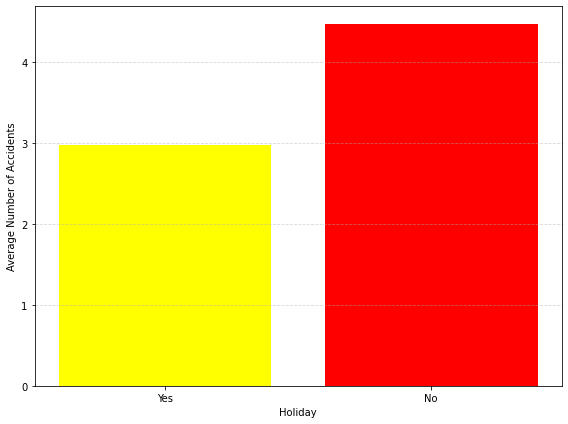

In [38]:
plt.figure(figsize=(8, 6))

# Filtrar el DataFrame para las semanas de vacaciones clasificadas como '1' y '0'
vacation_weeks = final_df[final_df['Holiday'] == 'Yes']
non_vacation_weeks = final_df[final_df['Holiday'] == 'No']

# Calcular el promedio de accidentes para cada tipo de semana de vacaciones
avg_vacation_accidents = vacation_weeks['Accidents'].mean()
avg_non_vacation_accidents = non_vacation_weeks['Accidents'].mean()

# Crear una lista de etiquetas para el eje x
labels = ['Yes', 'No']

# Crear una lista de datos para el eje y
avg_accidents = [avg_vacation_accidents, avg_non_vacation_accidents]

# Crear el gráfico de barras con colores personalizados
plt.bar(labels, avg_accidents, color=['yellow', 'red'])

# Agregar líneas horizontales en el fondo
plt.grid(True, linestyle='--', alpha=0.5, axis='y')

# Agregar etiquetas y título
plt.xlabel('Holiday')
plt.ylabel('Average Number of Accidents')

# Mostrar el gráfico
plt.tight_layout()
plt.show()


In [40]:
final_df['Vacation_week'].value_counts()

0    2856
1    1524
Name: Vacation_week, dtype: int64

In [41]:
2856/80

35.7

In [42]:
1524/24

63.5

In [43]:
1524

2930.769230769231